In [ ]:
# ! pip install torchxrayvision
# ! pip install pgmpy
# ! pip install kaggle
# !pip install networkx

Obtaining file:///content
ERROR: file:///content does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [179]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



100%|██████████| 600/600 [04:49<00:00,  2.07it/s]


Building tree:   0%|          | 0/1081.0 [00:00<?, ?it/s]

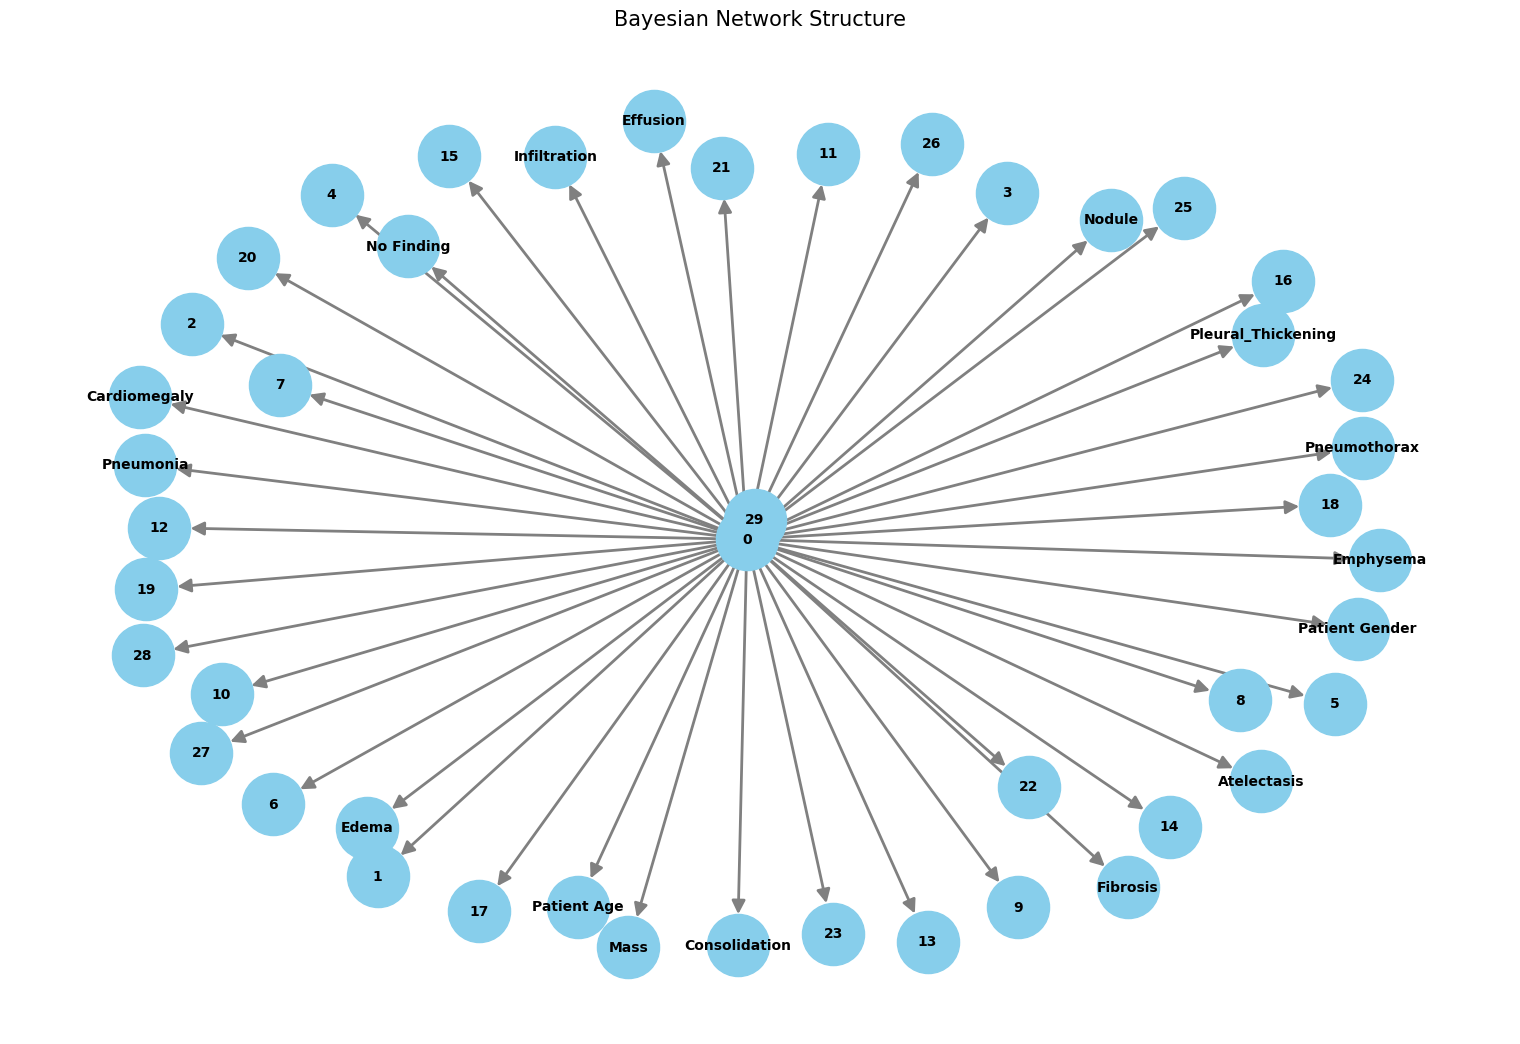

BIC score: -676036.68


In [ ]:

import os
import torchxrayvision as xrv
import torch
import pandas as pd
import numpy as np
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
from sklearn.decomposition import PCA
from pgmpy.estimators import TreeSearch
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.metrics import structure_score

def list_files(directory):
  try:
    return os.listdir(directory)
  except FileNotFoundError:
    return []

# Configuration
image_dir = "/content/images_001/images/"
num_images = 600  # Limit the number of images for processing

# Load and preprocess images
image_files = list_files(image_dir)[:num_images]

# Load pre-trained model and define transformations
model = xrv.models.DenseNet(weights="densenet121-res224-all")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Feature extraction function
def extract_features(image_path):
    image = Image.open(image_path).convert("L")
    image_tensor = transform(image).unsqueeze(0)
    with torch.no_grad():
        features = model.features(image_tensor)
        features = torch.flatten(features, start_dim=1)
    return features.cpu().numpy().flatten()

# Extract features from images
features_list = [extract_features(image_dir + path) for path in tqdm(image_files)]
df_features = pd.DataFrame(features_list)

# Dimensionality reduction
pca = PCA(n_components=30)
df_features_reduced = pd.DataFrame(pca.fit_transform(df_features))

# Load and preprocess labels
data_entry = pd.read_csv("Data_Entry_2017.csv")
img_files = data_entry[data_entry['Image Index'].isin(image_files)]
img_files = img_files[['Image Index', 'Finding Labels', 'Patient Age', 'Patient Gender']].reset_index(drop=True)

# Process labels
separated_labels = [labels.split('|') for labels in img_files['Finding Labels']]
all_labels = set([label for labels_list in separated_labels for label in labels_list])
for label in all_labels:
    img_files[label] = 0
for index, row in img_files.iterrows():
    for label in separated_labels[index]:
      img_files.loc[index, label] = 1
img_files = img_files.drop('Finding Labels', axis=1)

# Combine features and labels
df_final = pd.concat([img_files, df_features_reduced], axis=1)

# Split data into train and test sets
train = df_final.iloc[:500, 1:]
test = df_final.iloc[500:, 1:]

# Learn Bayesian Network structure
est_tree = TreeSearch(train)
best_model = est_tree.estimate()
network_tree = BayesianNetwork(best_model)

# Estimate CPDs and add them to the model
mle = MaximumLikelihoodEstimator(network_tree, df_final)
for cpd in mle.get_parameters():
    network_tree.add_cpds(cpd)

# Visualize the Bayesian network structure
G = nx.DiGraph()
G.add_nodes_from(network_tree.nodes())
G.add_edges_from(network_tree.edges())

plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=10, font_weight="bold", arrowsize=20, edge_color="gray", width=2)
plt.title("Bayesian Network Structure", fontsize=15)
plt.tight_layout()
plt.show()

# Evaluate the model
network_nodes = list(network_tree.nodes())
test = test[network_nodes]

score_tree = structure_score(network_tree, test, scoring_method="bic")
print(f"BIC score: {score_tree:.2f}")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
disease_list = [
    'No Finding',
    'Infiltration',
    'Effusion',
    'Atelectasis',
    'Cardiomegaly',
    'Nodule',
    'Fibrosis',
    'Consolidation',
    'Pneumothorax',
    'Mass',
    'Edema',
    'Pleural_Thickening',
    'Emphysema',
    'Pneumonia'
]

test_set = test.drop(columns=disease_list)
test_set

,29,0,1,2,3,4,5,6,7,8,...,21,22,23,24,25,26,27,28,Patient Age,Patient Gender
500,0.012179,-0.024241,0.008106,-0.032294,0.007882,-0.001476,-0.021058,-0.002105,0.005641,0.025830,...,0.003427,0.004390,-0.002129,-0.010827,-0.010563,0.008146,0.005023,-0.004485,18,F
501,-0.005968,0.079111,-0.026482,-0.070895,-0.097923,-0.001819,-0.006161,0.008566,-0.027111,-0.022532,...,-0.007040,0.004423,-0.005933,-0.013003,0.019062,0.000653,0.005140,0.013163,43,M
502,-0.005872,-0.002270,0.065709,-0.037554,-0.007458,-0.001785,-0.009706,-0.031115,-0.022557,-0.007165,...,-0.004016,0.000227,-0.001849,0.007522,0.009276,0.010834,0.003278,0.008191,23,F
503,0.018018,0.022210,-0.034428,0.081066,0.052849,-0.010861,-0.019966,-0.041554,-0.016717,-0.023979,...,-0.009275,0.035570,0.008475,-0.000789,-0.000014,-0.008023,0.023533,0.000749,63,F
504,-0.002548,-0.014819,0.051868,-0.010302,0.018688,0.022456,-0.025551,-0.009292,-0.021258,-0.009928,...,-0.009500,-0.004810,-0.001654,0.001863,-0.002059,0.007178,0.000911,0.000792,57,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,-0.007223,0.026574,-0.090858,0.045416,0.002117,-0.016395,-0.008045,-0.033792,-0.001465,-0.007147,...,-0.008261,-0.005839,-0.012251,0.003108,0.013557,-0.001517,-0.001382,-0.003372,57,F
596,-0.001110,0.033528,-0.067472,0.044101,0.016491,-0.033312,-0.030246,-0.013248,-0.003496,-0.010152,...,-0.011432,0.003254,-0.001595,0.006424,0.012141,0.000318,0.007951,-0.015753,14,M
597,0.006195,-0.038802,-0.052050,0.026429,-0.031241,0.031961,0.002276,-0.032384,-0.003188,0.053490,...,0.011104,0.008041,-0.003146,-0.002436,0.001273,-0.000974,0.013677,-0.002714,49,F
598,-0.005902,0.064033,-0.037959,0.009096,0.021110,0.026662,-0.004690,0.038004,0.013309,0.021652,...,-0.009756,0.011327,0.010263,-0.013842,-0.006748,-0.006535,-0.011815,0.017137,19,F


In [ ]:
from pgmpy.inference import VariableElimination

# Initialize Bayesian Inference
inference = VariableElimination(network_tree)

# Predict Disease Probability Given Features
# Use the test set for prediction.  Select a row from the test set as evidence.
evidence_row_index = 0  # Example: Use the first row of the test set
evidence = {}

# Use the original 'test' DataFrame to include all variables in the evidence
for col in test.columns:
    # Exclude the disease labels from the evidence to avoid circular reasoning
    if col not in disease_list:
        evidence[col] = test.iloc[evidence_row_index][col]

# Now predict probabilities for each disease
for disease in disease_list:
    try:
        query_result = inference.query(variables=[disease], evidence=evidence)
        print(f"Probability of {disease}: {query_result.values[1]}") # Print the probability of the disease being True
    except Exception as e:
        print(f"Error querying for {disease}: {e}")

print(query_result)

Probability of No Finding: 1.0
Probability of Infiltration: 0.0
Probability of Effusion: 0.0
Probability of Atelectasis: 0.0
Probability of Cardiomegaly: 0.0
Probability of Nodule: 0.0
Probability of Fibrosis: 0.0
Probability of Consolidation: 0.0
Probability of Pneumothorax: 0.0
Probability of Mass: 0.0
Probability of Edema: 0.0
Probability of Pleural_Thickening: 0.0
Probability of Emphysema: 0.0
Probability of Pneumonia: 0.0
+--------------+------------------+
| Pneumonia    |   phi(Pneumonia) |
+==============+==================+
| Pneumonia(0) |           1.0000 |
+--------------+------------------+
| Pneumonia(1) |           0.0000 |
+--------------+------------------+


In [ ]:
import pandas as pd
# Assuming 'network_tree' and 'test' are defined as in the previous code.

from pgmpy.inference import VariableElimination
from pgmpy.metrics import log_likelihood_score

# Initialize Bayesian Inference
inference = VariableElimination(network_tree)

# Function to predict probabilities for a given row of the test set
def predict_probabilities(evidence):
    probabilities = {}
    for disease in disease_list:
        try:
            query_result = inference.query(variables=[disease], evidence=evidence)
            probabilities[disease] = query_result.values[query_result.values.argmax()]
        except Exception as e:  # Handle cases where a variable might not be in the network
            print(f"Error querying for {disease}: {e}")
            probabilities[disease] = 0  # Assign 0 if the query fails

    return probabilities


# Evaluate on the entire test set
all_predictions = []
for index, row in test.iterrows():
    evidence = {}
    for col in test_set.columns:
        evidence[col] = row[col]

    all_predictions.append(predict_probabilities(evidence))

# Convert predictions to DataFrame
pred_df = pd.DataFrame(all_predictions)

# Calculate Log-Likelihood Score
# Use the entire test DataFrame for log-likelihood scoring, not just disease columns
# test_data = test[disease_list]  # This line is incorrect
# test_data = test[list(network_tree.nodes())]  # Use all nodes in the network
predicted_probabilities = pred_df[disease_list]
log_likelihood = log_likelihood_score(network_tree, test)
print(f"Log-likelihood score: {log_likelihood:.2f}")

#Further evaluation metrics (example: Precision, Recall, F1-score)

from sklearn.metrics import classification_report


# Calculate the classification report.
# Adapt the threshold and the true labels depending on your needs
threshold = 0.5  # Define a threshold for classifying predictions

y_true = test[disease_list]
y_pred = (predicted_probabilities > threshold).astype(int)


print(classification_report(y_true, y_pred, target_names=disease_list))

Log-likelihood score: -639.69
                    precision    recall  f1-score   support

        No Finding       0.55      1.00      0.71        55
      Infiltration       0.18      1.00      0.31        18
          Effusion       0.09      1.00      0.17         9
       Atelectasis       0.03      1.00      0.06         3
      Cardiomegaly       0.01      1.00      0.02         1
            Nodule       0.02      1.00      0.04         2
          Fibrosis       0.04      1.00      0.08         4
     Consolidation       0.07      1.00      0.13         7
      Pneumothorax       0.03      1.00      0.06         3
              Mass       0.03      1.00      0.06         3
             Edema       0.07      1.00      0.13         7
Pleural_Thickening       0.02      1.00      0.04         2
         Emphysema       0.02      1.00      0.04         2
         Pneumonia       0.02      1.00      0.04         2

         micro avg       0.08      1.00      0.16       118
        